# HDF assets from NASA-CMR

In [1]:
from eolearn.stac import STACInputTask
from eolearn.core import SaveTask, OverwritePermission, LinearWorkflow, EOExecutor
from sentinelhub import BBox, CRS
from datetime import date
import logging
import os

In [2]:
OUTPUT_DIR = "mod11a2-patches"
CACHE_DIR = "mod11a2-cache"

/home/munshkr/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
add_data = STACInputTask(
    catalog_url="http://localhost:3000/dev/stac/LPDAAC_ECS",
    collection_name="MOD11A2.v006",
    assets={"data"},
    subdataset="HDF4_EOS:EOS_GRID:%s:MODIS_Grid_8Day_1km_LST:LST_Day_1km",
)

save = SaveTask(
    OUTPUT_DIR,
    overwrite_permission=OverwritePermission.OVERWRITE_PATCH,
)

workflow = LinearWorkflow(
    add_data,
    save
)

In [5]:
bboxes = [
    BBox([-64.3097860799999808,-31.5249839339999767, -64.0573813509999468,-31.3085281599999803], CRS('4326'))
]
time_interval = (date(2020, 10, 1), date(2020, 10, 31))

## Debug

In [6]:
# logging.basicConfig(level=logging.DEBUG)

In [7]:
# add_data.execute(bbox=bboxes[0], time_interval=time_interval)

## Workflow

In [8]:
execution_args = []
for i, bbox in enumerate(bboxes):
    execution_args.append(
        {
            add_data: {"bbox": bbox, "time_interval": time_interval},
            save: {"eopatch_folder": str(i)},
        }
    )

In [9]:
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_filename()}"
    )

  0%|          | 0/1 [00:00<?, ?it/s]

## Visualize patches

In [33]:
from eolearn.core import EOPatch
import matplotlib.pyplot as plt

In [34]:
patch = EOPatch.load(os.path.join(OUTPUT_DIR, "0"))
patch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(4, 26, 42, 1), dtype=uint16)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    size_x: 42
    size_y: 26
    stac_items: '[[[[{"type": "Feature", "id": "SC:MOD11A2.006:2412510512", "stac_version": "1.0.0", "stac_extensions": [], "collection": "MOD11A2.v006", "geometry": {"type": "Polygon", "coordinates": [[[-78.3298664, -39.9958333], [-65.2758149, -39.9958333], [-57.7446983, -30.0041667], [-69.2926546, -30.0041667], [-78.3298664, -39.9958333]]]}, "bbox": [-78.329866, -40.179391, -57.744698, -30.004167], "links": [{"rel": "self", "href": "http://localhost:3000/dev/stac/LPDAAC_ECS/collections/MOD11A2.v006/items/SC:MOD11A2.006:2412510512"}, {"rel": "parent", "href": "http://localhost:3000/dev/stac/LPDAAC_ECS/collections/MOD11A2.v006"}, {"rel": "collection", "href": "http://localhost:3000/dev/stac/LPDAAC_ECS/collec

In [39]:
img = patch.data['BANDS'][0, ..., 0]
valid_img = img[img > 0]
valid_img.min(), valid_img.max()

(15175, 15579)

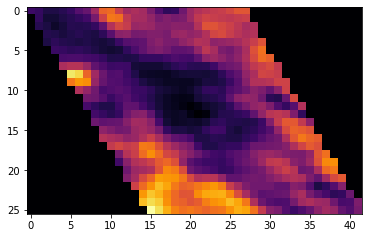

In [41]:
plt.imshow(img, vmin=15175, vmax=15579, cmap='inferno')